In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances

import utils.sulfur.constant as const
from utils.CaImageCSV import CaImageCSV

In [2]:
def droped_unique_cells(cells1, cells2):
    droped_cells = np.array([])
    droped_cells = np.append(droped_cells, cells1)
    droped_cells = np.append(droped_cells, cells2)
    droped_cells = np.unique(droped_cells)
    return droped_cells

def all_nan_cells(matrix):
    nan_cells = np.array([])
    for cell_name, items in matrix.iteritems():
        if items.isnull().all():
            nan_cells = np.append(nan_cells, cell_name)
            
    return nan_cells

def splitted_context_name(context_name, index):
    return '%s_%d' % (context_name, index)

def build_matrix_index(context_name, cells):
    index_df = pd.DataFrame(data=([context_name] * len(cells)))
    index_df.columns = ['context']
    cells = cells.reset_index(drop=True)
    index_df['cell_name'] = cells
    return pd.MultiIndex.from_frame(index_df, names=['context_name', 'cell_name'])

def split_matrix(matrix, context_name):
    matrix_1 = matrix.iloc[0:400, :]
    matrix_2 = matrix.iloc[900:1300, :]
    matrix_3 = matrix.iloc[1800:2200, :]
    
    matrix_1.rename(lambda x: splitted_context_name(x, 1), inplace=True)
    matrix_2.rename(lambda x: splitted_context_name(x, 2), inplace=True)
    matrix_3.rename(lambda x: splitted_context_name(x, 3), inplace=True)
    
    return matrix_1, matrix_2, matrix_3

def split_engram_matrix(origin, context_name):
    matrix = origin.filtered_by_context(context_name).astype(float).copy(deep=True)
    matrix = origin.optimize_std(matrix)
    matrix.reset_index(level=1, drop=True, inplace=True)
    
    engram_matrix = matrix.loc[:, origin.engram_cells()]
    non_engram_matrix = matrix.loc[:, csv.non_engram_cells()]
    
    return engram_matrix, non_engram_matrix

In [6]:
index = const.ANIMAL_NAMES
column_df = pd.DataFrame()
column_df['cell type'] = ['engram', 'engram', 'non-engram', 'non-engram']
column_df['context'] = ['A1postES', 'B1'] * 2
columns = pd.MultiIndex.from_frame(column_df)
across_session_df = pd.DataFrame(0.0, columns=columns, index=index)
inner_session_df = pd.DataFrame(0.0, columns=columns, index=index)
for animal_name in const.ANIMAL_NAMES:
    file_path = './resources/%s_Longitudinal_Traces.csv' % animal_name
    csv = CaImageCSV(file_path)
    
    # A1postES
    A1postES_engram, A1postES_non_engram = split_engram_matrix(csv, 'A1postES')
    
    A1postES_nan_engram_cells = all_nan_cells(A1postES_engram)
    A1postES_nan_non_engram_cells = all_nan_cells(A1postES_non_engram)
    
    # B1
    B1_engram, B1_non_engram = split_engram_matrix(csv, 'B1')
    
    B1_nan_engram_cells = all_nan_cells(B1_engram)
    B1_nan_non_engram_cells = all_nan_cells(B1_non_engram)
    
    # fetch dropped cells
    dropped_engram_cells = droped_unique_cells(A1postES_nan_engram_cells, B1_nan_engram_cells)
    dropped_non_engram_cells = droped_unique_cells(A1postES_nan_non_engram_cells, B1_nan_non_engram_cells)
    
    # A1postES
    A1postES_engram.drop(columns=dropped_engram_cells, inplace=True)
    A1postES_non_engram.drop(columns=dropped_non_engram_cells, inplace=True)
    
    A1postES_engram = A1postES_engram.iloc[1800:2200, :]
    A1postES_non_engram = A1postES_non_engram.iloc[1800:2200, :]
    
    # B1
    B1_engram.drop(columns=dropped_engram_cells, inplace=True)
    B1_non_engram.drop(columns=dropped_non_engram_cells, inplace=True)
    
    B1_engram = B1_engram.iloc[2600:3000, :]
    B1_non_engram = B1_non_engram.iloc[2600:3000, :]
    
    across_session_df.loc[animal_name, ('engram', 'A1postES')] = np.mean(pairwise_distances(A1postES_engram, A1postES_engram))
    across_session_df.loc[animal_name, ('engram', 'B1')]       = np.mean(pairwise_distances(A1postES_engram, B1_engram))
    
    across_session_df.loc[animal_name, ('non-engram', 'A1postES')] = np.mean(pairwise_distances(A1postES_non_engram, A1postES_non_engram))
    across_session_df.loc[animal_name, ('non-engram', 'B1')]       = np.mean(pairwise_distances(A1postES_non_engram, B1_non_engram))
    
    inner_session_df.loc[animal_name, ('engram', 'A1postES')] = np.mean(pairwise_distances(A1postES_engram, A1postES_engram))
    inner_session_df.loc[animal_name, ('engram', 'B1')]       = np.mean(pairwise_distances(B1_engram, B1_engram))
    
    inner_session_df.loc[animal_name, ('non-engram', 'A1postES')] = np.mean(pairwise_distances(A1postES_non_engram, A1postES_non_engram))
    inner_session_df.loc[animal_name, ('non-engram', 'B1')]       = np.mean(pairwise_distances(B1_non_engram, B1_non_engram))
    

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [22]:
across_session_df.to_csv('./resources/pairwise_distance/other_context/across_session.csv')

In [23]:
inner_session_df.to_csv('./resources/pairwise_distance/other_context/inner_session.csv')

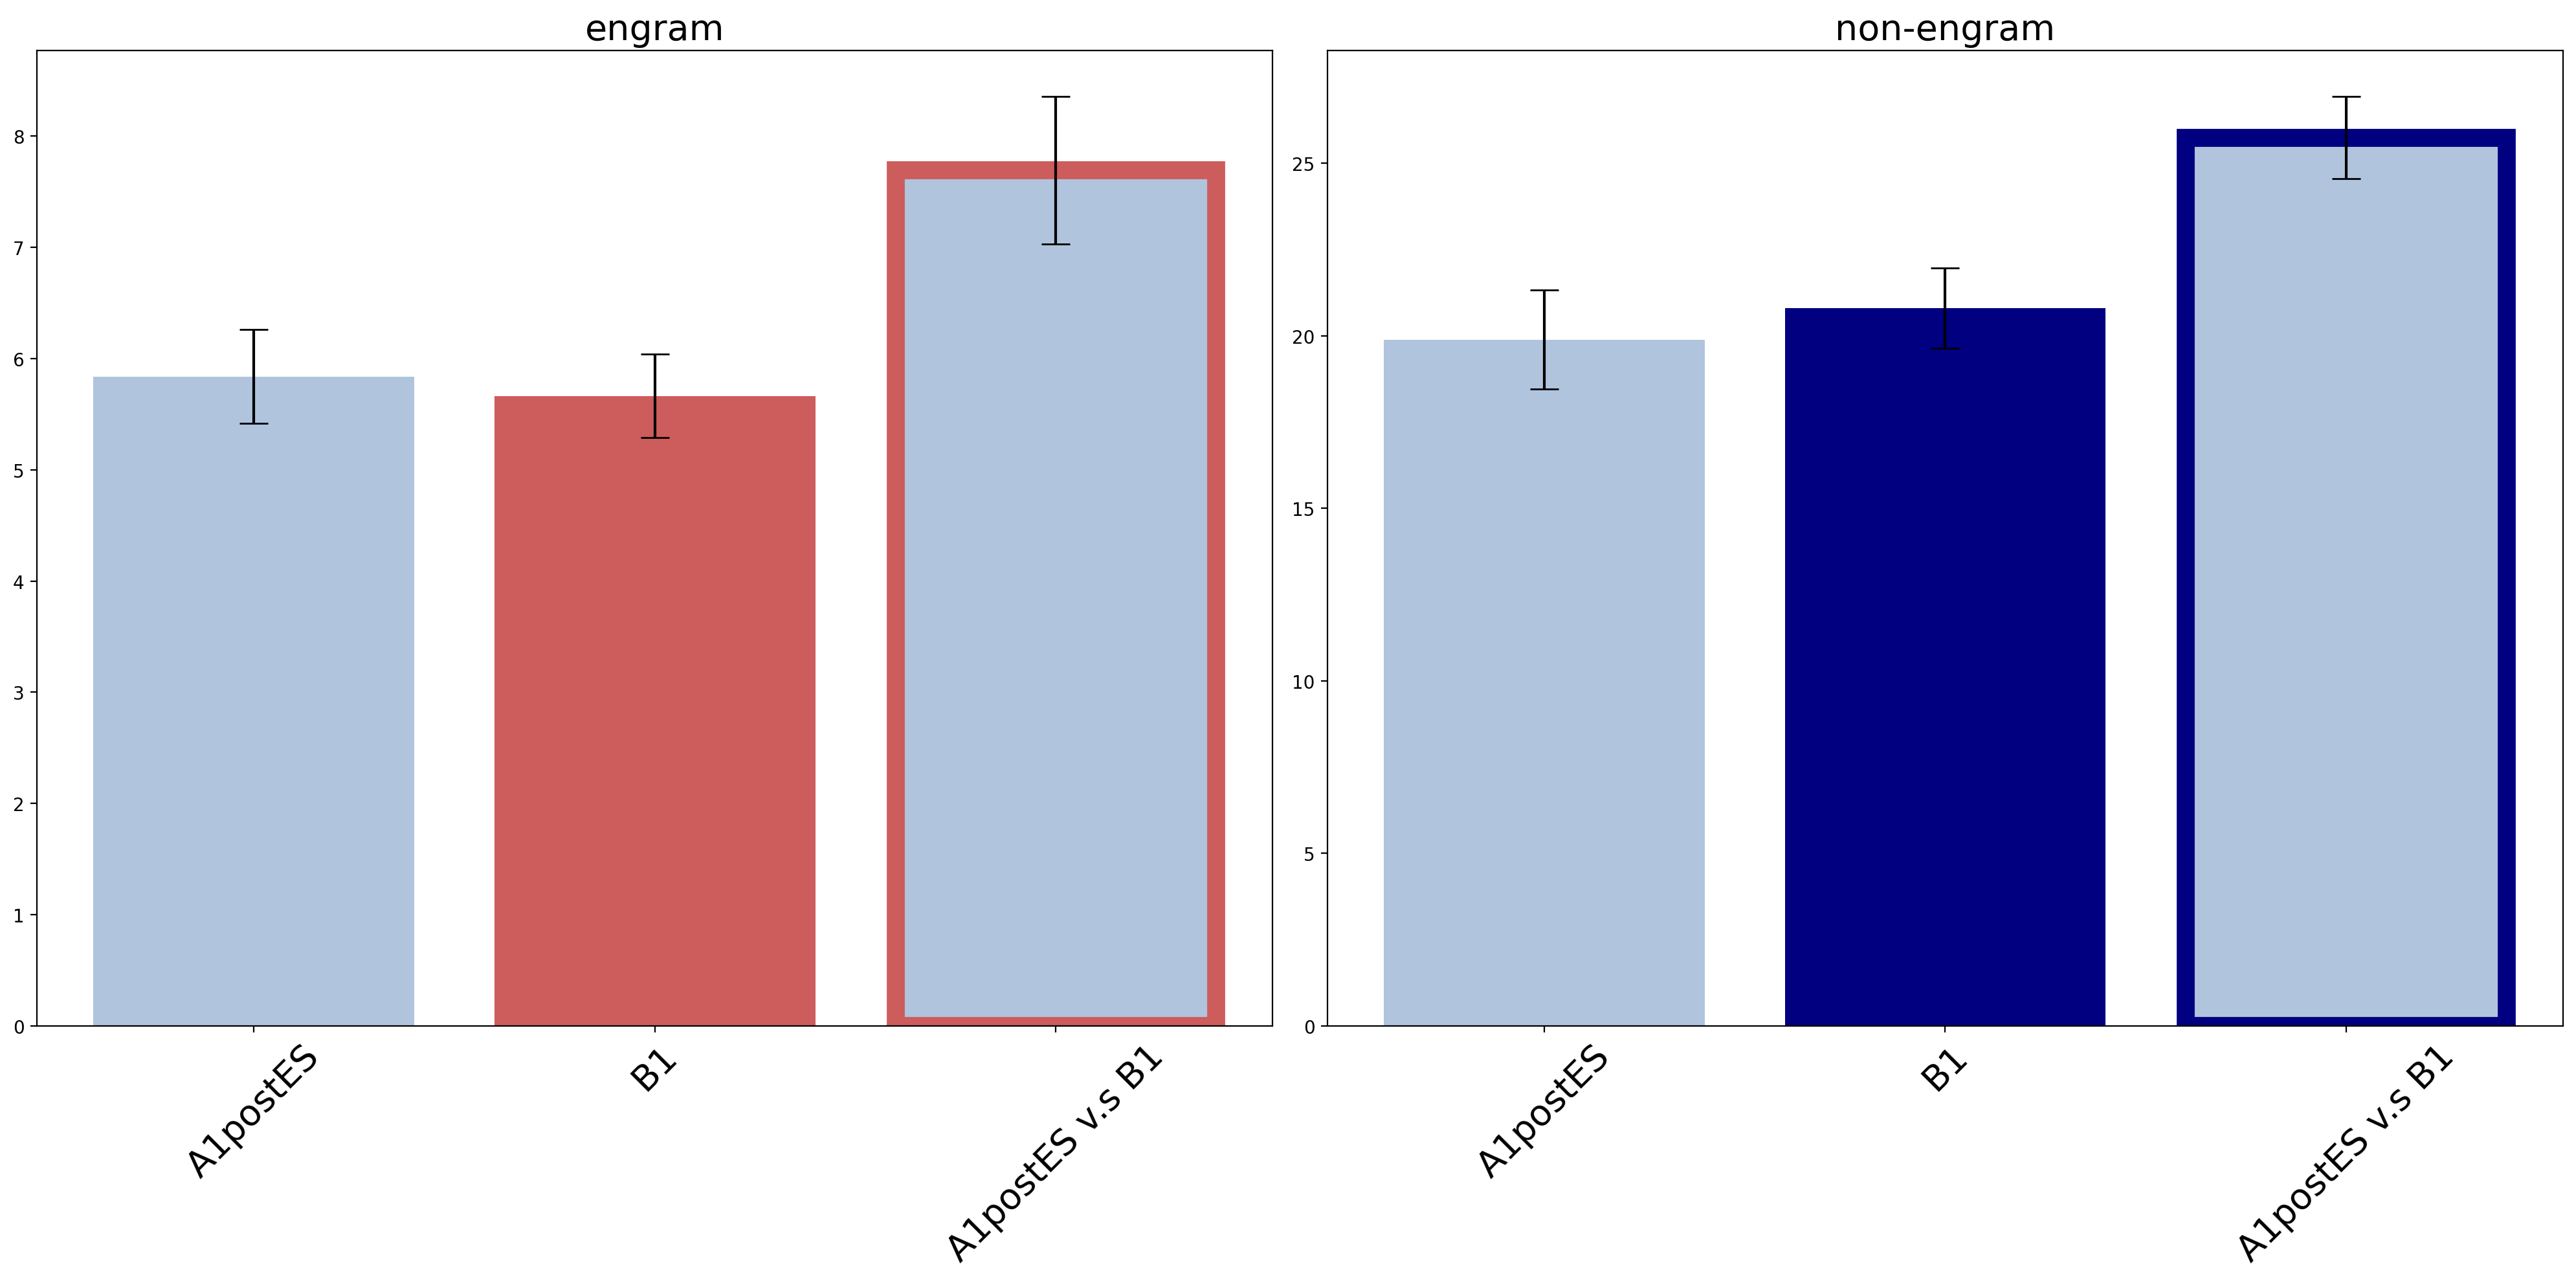

In [21]:
engram_across_df = across_session_df.iloc[:, 0:2]
non_engram_across_df = across_session_df.iloc[:, 2:]

engram_inner_df = inner_session_df.iloc[:, 0:2]
non_engram_inner_df = inner_session_df.iloc[:, 2:]

base_session_color = 'lightsteelblue'

fig, axes = plt.subplots(ncols=2, figsize=(20, 10), dpi=200)
axes[0].set_title('engram', fontsize=20)
axes[0].bar(x=0, height=engram_inner_df.iloc[:, 0].mean(), yerr=engram_inner_df.iloc[:, 0].sem(), capsize=8, align='center',color=base_session_color)
axes[0].bar(x=1, height=engram_inner_df.iloc[:, 1].mean(), yerr=engram_inner_df.iloc[:, 1].sem(), capsize=8, align='center',color='indianred')
axes[0].bar(x=2, height=engram_across_df.iloc[:, 1].mean(), yerr=engram_across_df.iloc[:, 1].sem(), capsize=8, align='center',color=base_session_color, linewidth=10, edgecolor='indianred')
axes[0].set_xticks([0, 1, 2])
axes[0].set_xticklabels(['A1postES', 'B1', 'A1postES v.s B1'], rotation=45, fontsize=20)

axes[1].set_title('non-engram', fontsize=20)
axes[1].bar(x=0, height=non_engram_inner_df.iloc[:, 0].mean(), yerr=non_engram_inner_df.iloc[:, 0].sem(), capsize=8, align='center',color=base_session_color)
axes[1].bar(x=1, height=non_engram_inner_df.iloc[:, 1].mean(), yerr=non_engram_inner_df.iloc[:, 1].sem(), capsize=8, align='center',color='navy')
axes[1].bar(x=2, height=non_engram_across_df.iloc[:, 1].mean(), yerr=non_engram_across_df.iloc[:, 1].sem(), capsize=8, align='center',color=base_session_color, linewidth=10, edgecolor='navy')
axes[1].set_xticks([0, 1, 2])
axes[1].set_xticklabels(['A1postES', 'B1', 'A1postES v.s B1'], rotation=45, fontsize=20)

fig.tight_layout()
plt.show()